<a href="https://colab.research.google.com/github/jmcinern/NLP_QUB/blob/main/Linguistic_Insights_JosephMcInerney_40460549_section1code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linguistic Insights from Dataset

## 1.0 Build Dataset

connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
pth = '/content/drive/MyDrive/NLP/Project'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install -r '{pth}/requirements.txt'

Read JSON file storing data

In [ ]:
import json
import os

In [ ]:
# Stories dataset in same dir as notebook.
fn = 'stories.json'
with open(os.path.join(pth, fn), 'r') as ifh:
    data = json.load(ifh)

Have a look at first entry

In [ ]:
for story in data['stories']:
    print(story.keys())
    break

dict_keys(['index', 'theme', 'setting', 'person', 'style', 'outcome', 'object_concept', 'story', 'question1', 'answer1', 'question2', 'answer2'])


In [ ]:
print(len(data['stories'])) # 602 stories, not 600.

602


## 1.1 Writing Style and Dependancy Parsing

Using average maximimum dependency length as a proxy for language complexity of a text. Then seeing if particular styles vary in relation to language complexity.

### 1.1a Dependancy Parsing as a Proxy for Language Complexity

Calculate average maximum dependancy lenght for each text

In [ ]:
import numpy as np

Maximum dependancy for a sentence using the spaCy dependency parser to idenify depenencies.

In [ ]:
# function that returns the longest dependancy span in a sentence
def sentence_max_dep(sentence):
    max_distance = 0
    for token in sentence:
        dependant_idx = token.head.i
        distance = abs(token.i - dependant_idx)  # use absolute distance
        if distance > max_distance:
            max_distance = distance

    return max_distance

In [ ]:
# if spaCy not installed:
'''
# load spaCy model for dependancy parsing and sentence splitting.
!pip install -q spacy
!python -m spacy download en_core_web_sm --quiet
'''
import spacy
nlp = spacy.load('en_core_web_sm', enable=['tok2vec']) # load just once
nlp.add_pipe('parser')

use doc.sents in spacy to tokenize by sentence, use previous function to caluclate max dependency length for each sentence, calculate mean of these lengths for average max.

In [ ]:
# function that takes a text as input and returns th mean max dependancy of sentences in that text
def ave_max_dep(story_txt):
  # list storing max depth per sentence
  max_deps = []
  for sentence in story_txt.sents:
    max_deps.append(sentence_max_dep(sentence))

  return np.mean(max_deps)

loop through JSON file, for each story, pass spacy NLP object to calculate ave_max_dep and add value to JSON obj

In [ ]:
from tqdm import tqdm

In [ ]:
# loop through all stories in data set
for story in tqdm(data['stories']):
  # get text
  story_txt = story['story']

  # split text into sentences
  doc = nlp(story_txt)

  # get ave max sentence dependancy for this story
  ave_max_dep_val =  ave_max_dep(doc)

  # add this information to json obj
  story['ave_max_dep'] = ave_max_dep_val

100%|██████████| 602/602 [01:01<00:00,  9.83it/s]


max average dependency for first story

In [ ]:
for story in data['stories']:
    print(story['ave_max_dep'])
    break

23.25


### 1.1b Complexity Variance by Style

five different styles: “descriptive”, “concise”, “poetic”, “journalistic” and “for children”. Get max ave dep distribution for each style.

In [ ]:
import pandas as pd

In [ ]:
# use lists as faster computationally
styles_complexity_distributions_lists = {
    'descriptive' : [],
    'concise' : [],
    'poetic': [],
    'journalistic': [],
    'for children': []
    }
# Get max_ave_dep distributions by style
for story in data['stories']:
  # get style
  style = story['style']

  # get complexity (ave max dependency)for this story
  ave_max_dep_val = story['ave_max_dep']

  # add complexity to relevant style ditribution
  styles_complexity_distributions_lists[style].append(ave_max_dep_val)

Generate rainbow plots to compare complexity distributions across styles.

Using ptitprince python package:
 Allen, M., Poggiali, D., Whitaker, K., Marshall, T. R., van Langen, J., & Kievit, R. A.
    Raincloud plots: a multi-platform tool for robust data visualization [version 2; peer review: 2 approved]
    Wellcome Open Research 2021, 4:63. https://doi.org/10.12688/wellcomeopenres.15191.2

In [ ]:
!pip install -q ptitprince

requirements.txt for ptitprince:
matplotlib  matplotlib 3.8 ,numpy>=1.13, scipy, seaborn =0.13, ptitprince

> Ajouter une citation



In [ ]:
import ptitprince as pt # for rainbow plots
import matplotlib.pyplot as plt

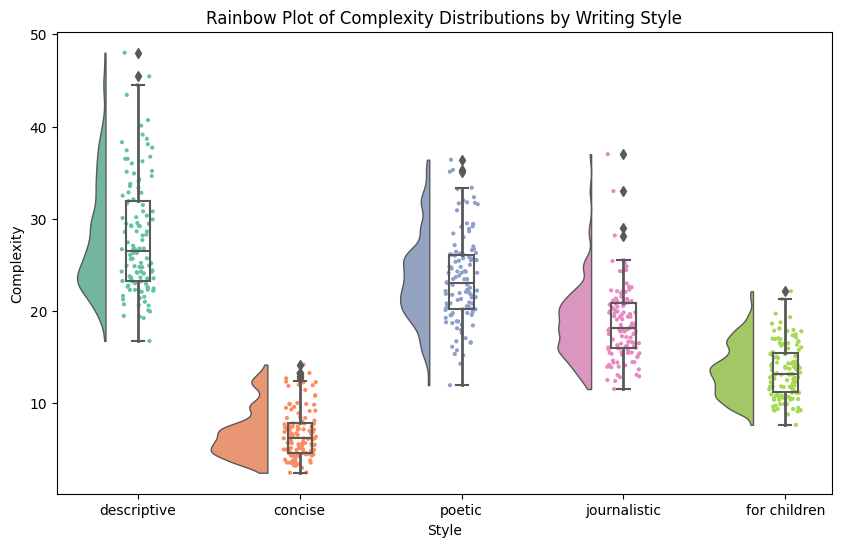

In [ ]:
# convert dictionary of lists into 'long-format' DataFrame as pt requires dataframe,
# - long format so as to handle varying list lengths.
data_complexity_for_style = []
for style, distribution in styles_complexity_distributions_lists.items():
    data_complexity_for_style.extend({"Style": style, "Complexity": value} for value in distribution)

# long-format df
df = pd.DataFrame(data_complexity_for_style)

# petit prince raincloud plot, plot dfs
plt.figure(figsize=(10, 6))
pt.RainCloud(x="Style", y="Complexity", data=df, orient="v", width_viol=0.7)

plt.xlabel("Style")
plt.ylabel("Complexity")
plt.title("Rainbow Plot of Complexity Distributions by Writing Style")
plt.show()

Here we can see that while the dependency length does seem to model complexity well in the case:

children  - poetic / journalistic

we can also see that it correlates to texts being

concise - descriptive

In [ ]:
'''
style_desc_dict = {"descriptive": "long sentences, rich modifiers",
                  "concise": "shorter sentences, fewer modifiers",
                  "poetic": "complex sentence structures, metaphorical language",
                  "journalistic": "neutral, declarative sentences with medium complexity",
                  "for children": "simple sentence structures, simple vocabulary"}
'''

'\nstyle_desc_dict = {"descriptive": "long sentences, rich modifiers",\n                  "concise": "shorter sentences, fewer modifiers",\n                  "poetic": "complex sentence structures, metaphorical language",\n                  "journalistic": "neutral, declarative sentences with medium complexity",\n                  "for children": "simple sentence structures, simple vocabulary"}\n'

## 1.2 POS

### 1.2a Compare POS Frequency by Writing Style.

In [ ]:
import nltk
from collections import Counter
# Download required resources
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('punkt_tab')

def POS_freq(text):
  # get POS tags using Penn Treebank {'word': pos}
  pos_tags = nltk.pos_tag(text)

  # get just POS tags and generate counts
  pos_list = []
  for word, tag in pos_tags:
    pos_list.append(tag)

  pos_counts = Counter(pos_list)

  # return frequencies (as dict)
  return dict(pos_counts)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# UPenn Tags
nltk.download('tagsets_json')
#nltk.help.upenn_tagset()

[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.


True

In [ ]:
# initialise empty dictionaries to store POS and freq for each style.
style_POS_freq = {'descriptive': {},
                  'concise': {},
                  'poetic': {},
                  'journalistic': {},
                  'for children': {}
                  }

# count number of texts per style for normalisation
style_counts = {}

# for each story
for story in tqdm(data['stories']):
  # get text
  story_text = story['story']
  # get style
  style = story['style']
  # increase style count
  style_counts[style] = style_counts.get(style, 0) + 1

  # tokenize
  tokens = nltk.word_tokenize(story_text)
  N = len(tokens)
  # get frequency of each POS for that story text.
  pos_counts = POS_freq(tokens)
  # normalize
  pos_freq_normalized = {tag: count / N for tag, count in pos_counts.items()}


  # for all POS : freqs
  for pos, count in pos_freq_normalized.items():
      # add to style,
      style_POS_freq[style][pos] = style_POS_freq[style].get(pos, 0) + count
  else:
    style_POS_freq[style] = pos_freq_normalized


100%|██████████| 602/602 [00:35<00:00, 16.91it/s]


In [ ]:
style_sum = {}
for style in style_POS_freq:
  style_sum[style] = sum(style_POS_freq[style].values())

style_sum

{'descriptive': 0.9999999999999999,
 'concise': 1.0000000000000002,
 'poetic': 1.0,
 'journalistic': 1.0000000000000002,
 'for children': 0.9999999999999999}

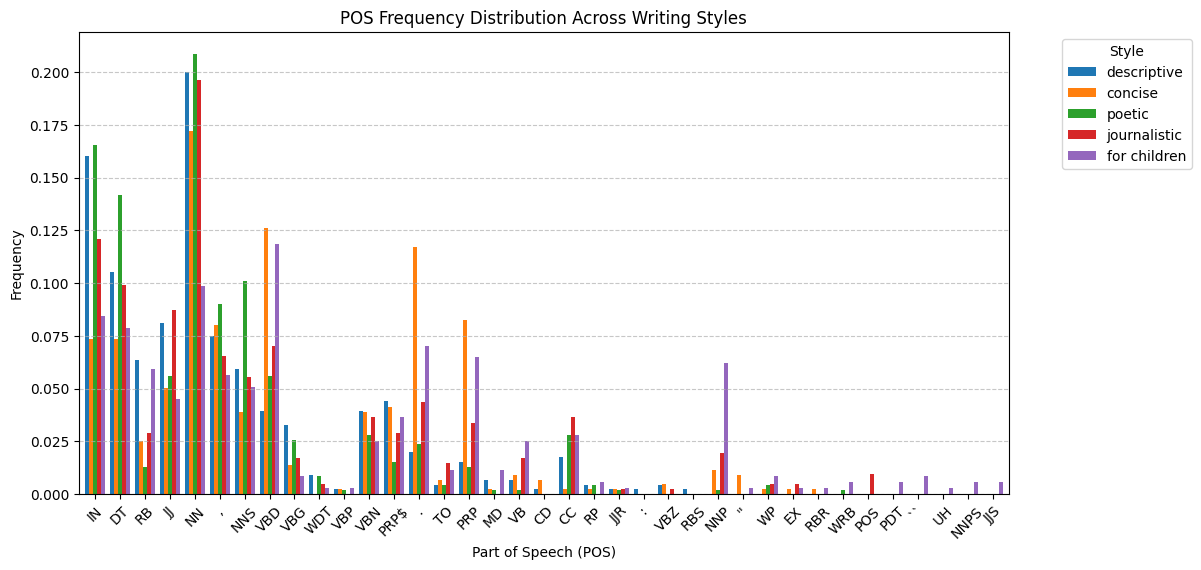

In [ ]:
# dictionary to DataFrame
style_POS_freq_df = pd.DataFrame(style_POS_freq).fillna(0)

# Plot POS tag distributions for different styles
style_POS_freq_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("POS Frequency Distribution Across Writing Styles")
plt.xlabel("Part of Speech (POS)")
plt.ylabel("Frequency")
plt.legend(title="Style", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### 1.2b POS Variation by Story Outcome

In [ ]:
# data structure to story POS tag distributions by outcome, so the 'victory' outcome
# -will have the POS freq dict for all stories with victory,
outcome_pos_count = {'defeat': [], 'victory': []}
for story in tqdm(data['stories']):
    # get text and tokenize
    text = story['story']
    text_tokenized = nltk.word_tokenize(text)

    # get story outcome
    outcome = story['outcome']
    # pos frequencies for this story.
    pos_counts = POS_freq(text_tokenized)
    # Add POS counts for current story (stories stored as a list of dictionaries)
    outcome_pos_count[outcome].append(pos_counts)


100%|██████████| 602/602 [00:12<00:00, 48.85it/s]


In [ ]:
POS_hypothesis = {'NN': {'victory': [], 'defeat': []},
                  'IN': {'victory': [], 'defeat': []},
                  'VBD': {'victory': [], 'defeat': []},
                  'DT': {'victory': [], 'defeat': []},
                  'PRP': {'victory': [], 'defeat': []},
                  }

for tag in POS_hypothesis:
  for outcome, pos_counts in outcome_pos_count.items():
    for POS_count in pos_counts:
      if tag in POS_count:
        POS_hypothesis[tag][outcome].append(POS_count[tag])

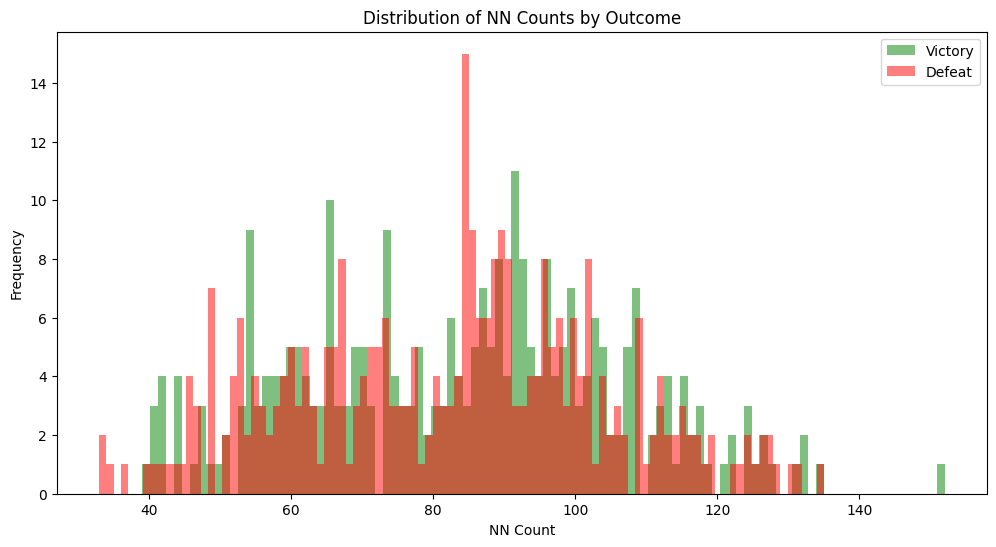

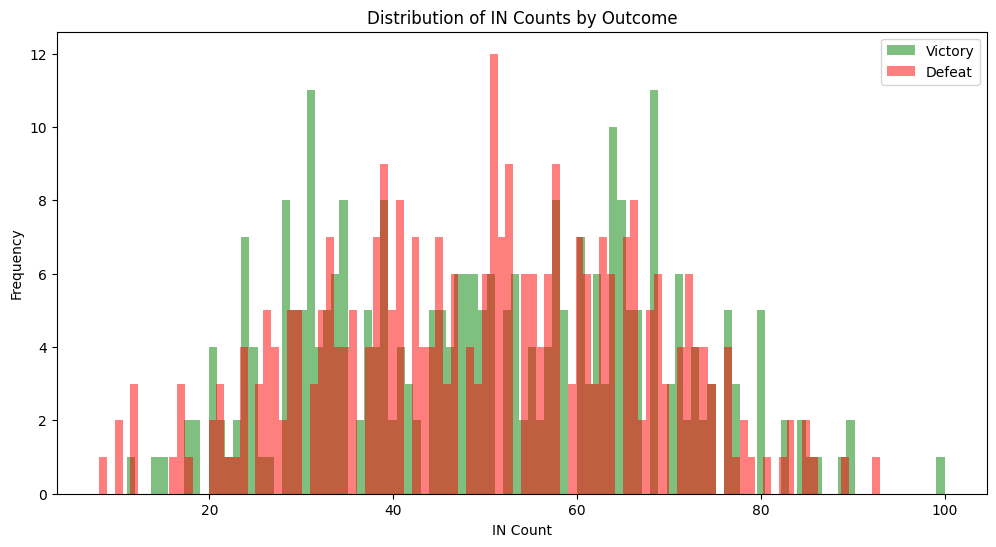

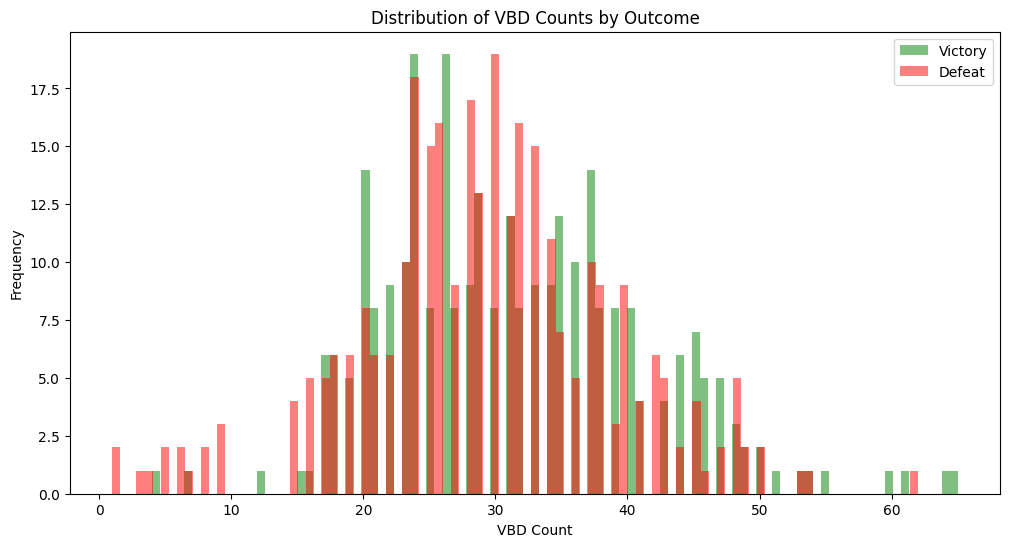

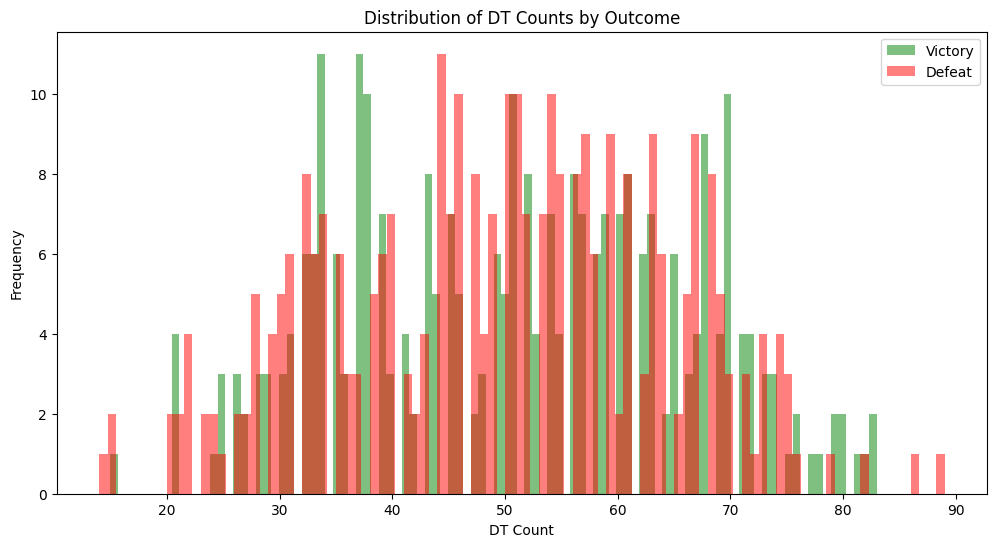

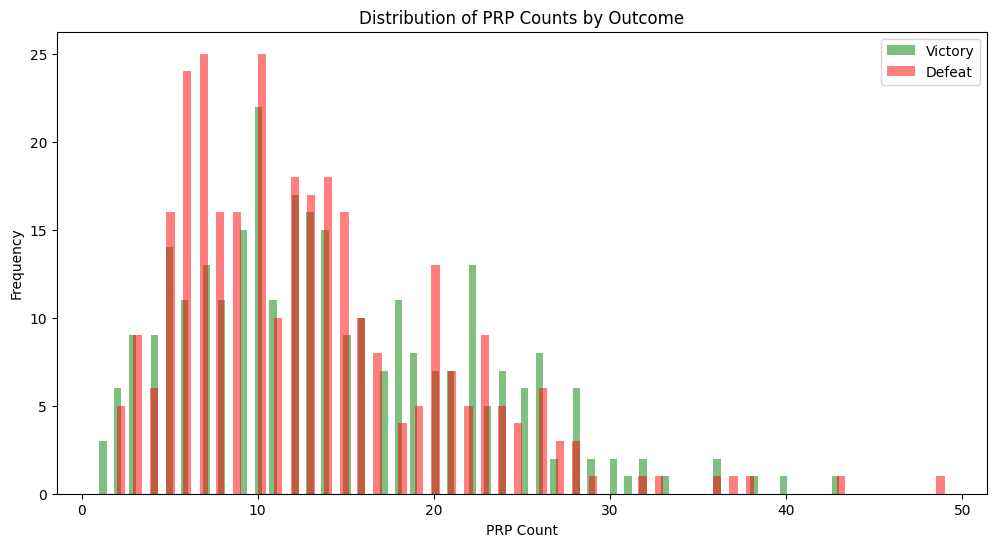

In [ ]:
for POS in POS_hypothesis:
  plt.figure(figsize=(12, 6))
  bins = 100

  plt.hist(POS_hypothesis[POS]['victory'], bins=bins, alpha=0.5, label='Victory', color='green')
  plt.hist(POS_hypothesis[POS]['defeat'], bins=bins, alpha=0.5, label='Defeat', color='red')

  plt.xlabel(f'{POS} Count')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {POS} Counts by Outcome')
  plt.legend()

  plt.show()

In [ ]:
# See whether the two distributions differ significantly, don't assume normality
from scipy.stats import mannwhitneyu

tests = ['less', 'greater', 'two-sided']

for test in tests:
  print(f'Test: {test}\n')
  # Extract data for the two outcomes
  for tag in POS_hypothesis:
    data_victory = POS_hypothesis[tag]['victory']
    data_defeat = POS_hypothesis[tag]['defeat']

    # Perform the Mann-Whitney U test: 'two sided' the means differ, not directional.
    u_statistic, p_value = mannwhitneyu(data_victory, data_defeat, alternative=test)

    print(f"POS: {tag}")
    print(f"Mann-Whitney U statistic: {u_statistic}")
    print(f"p-value: {p_value}\n")
    if p_value < 0.05:
      print(f"Significant (p<0.05) difference between victory and defeat outcomes.\n({test})")


Test: less

POS: NN
Mann-Whitney U statistic: 46814.5
p-value: 0.7684413124264757

POS: IN
Mann-Whitney U statistic: 45267.0
p-value: 0.5031807730521721

POS: VBD
Mann-Whitney U statistic: 48997.5
p-value: 0.9664638834187081

POS: DT
Mann-Whitney U statistic: 47442.5
p-value: 0.8481088217284867

POS: PRP
Mann-Whitney U statistic: 49204.0
p-value: 0.9682831584428865

Test: greater

POS: NN
Mann-Whitney U statistic: 46814.5
p-value: 0.2317016560647182

POS: IN
Mann-Whitney U statistic: 45267.0
p-value: 0.49700632762325325

POS: VBD
Mann-Whitney U statistic: 48997.5
p-value: 0.03357122375018661

Significant (p<0.05) difference between victory and defeat outcomes.
(greater)
POS: DT
Mann-Whitney U statistic: 47442.5
p-value: 0.1520014799137096

POS: PRP
Mann-Whitney U statistic: 49204.0
p-value: 0.03175030309352401

Significant (p<0.05) difference between victory and defeat outcomes.
(greater)
Test: two-sided

POS: NN
Mann-Whitney U statistic: 46814.5
p-value: 0.4634033121294364

POS: IN
Ma